In [5]:
import numpy as np
import pandas as pd  #读取csv文件的库
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
#让输出图形直接在Notebook中显示
% matplotlib inline

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


Text(0, 0.5, 'Y')

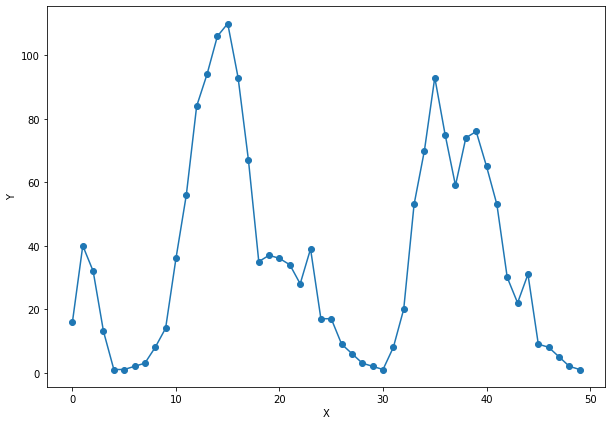

In [6]:
data_path = 'hour.csv'  #读取数据到内存，rides为一个dataframe对象
rides = pd.read_csv(data_path)
print(rides.head())  #输出部分数据
counts = rides['cnt'][:50]  #截取数据
x = np.arange(len(counts))  #获取变量x
y = np.array(counts)  #单车数量为y
plt.figure(figsize=(10, 7))  #设定绘图窗口大小
plt.plot(x, y, 'o-')  #绘制原始数据
plt.xlabel('X')  #更改坐标轴标注
plt.ylabel('Y')  #更改坐标轴标注

In [7]:
#输入变量，1,2,3,...这样的一维数组
x = torch.FloatTensor(np.arange(len(counts), dtype=float))
#输出变量，它是从数据counts中读取的每一时刻的单车数，共50个数据点的一维数组，作为标准答案
y = torch.FloatTensor(np.array(counts, dtype=float))

In [8]:
sz = 10  #设置隐含层神经元的数量
#初始化输入层到隐含层的权重矩阵，它的尺寸是(1,10)
weights = torch.randn((1, sz), requires_grad=True)
#初始化隐含层节点的偏置向量，它是尺寸为10的一维向量
biases = torch.randn((sz), requires_grad=True)
#初始化从隐含层到输出层的权重矩阵，它的尺寸是(10,1)
weights2 = torch.randn((sz, 1), requires_grad=True)

In [9]:
learning_rate = 0.001  #设置学习率
losses = []  #该数组记录每一次迭代的损失函数值，以方便后续绘图
x = x.view(50, -1)
y = y.view(50, -1)
for i in range(100000):
    #从输入层到隐含层的计算
    hidden = x * weights + biases
    #此时，hidden变量的尺寸是：(50,10)，即50个数据点，10个隐含层神经元

    #将sigmoid函数作用在隐含层的每一个神经元上
    hidden = torch.sigmoid(hidden)
    #隐含层输出到输出层，计算得到最终预测
    predictions = hidden.mm(weights2)
    #此时，predictions的尺寸为：(50,1)，即50个数据点的预测数值
    #通过与数据中的标准答案y做比较，计算均方误差
    loss = torch.mean((predictions - y) ** 2)
    #此时，loss为一个标量，即一个数
    losses.append(loss.data.numpy())

    if i % 10000 == 0:  #每隔10000个周期打印一下损失函数数值
        print('loss:', loss)

    #*****************************************
    #接下来开始梯度下降算法，将误差反向传播
    loss.backward()  #对损失函数进行梯度反传

    #利用上一步计算中得到的weights，biases等梯度信息更新weights或biases的数值
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)

    #清空所有变量的梯度值
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()

loss: tensor(2345.7925, grad_fn=<MeanBackward0>)
loss: tensor(865.0408, grad_fn=<MeanBackward0>)
loss: tensor(596.3130, grad_fn=<MeanBackward0>)
loss: tensor(511.3351, grad_fn=<MeanBackward0>)
loss: tensor(474.1242, grad_fn=<MeanBackward0>)
loss: tensor(468.5584, grad_fn=<MeanBackward0>)
loss: tensor(467.2853, grad_fn=<MeanBackward0>)
loss: tensor(466.2778, grad_fn=<MeanBackward0>)
loss: tensor(465.4675, grad_fn=<MeanBackward0>)
loss: tensor(464.8812, grad_fn=<MeanBackward0>)


Text(0, 0.5, 'Loss')

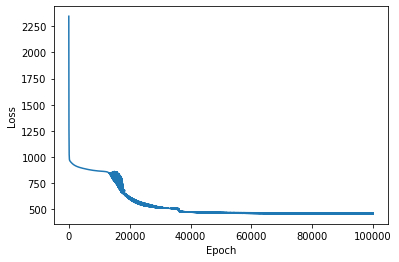

In [10]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

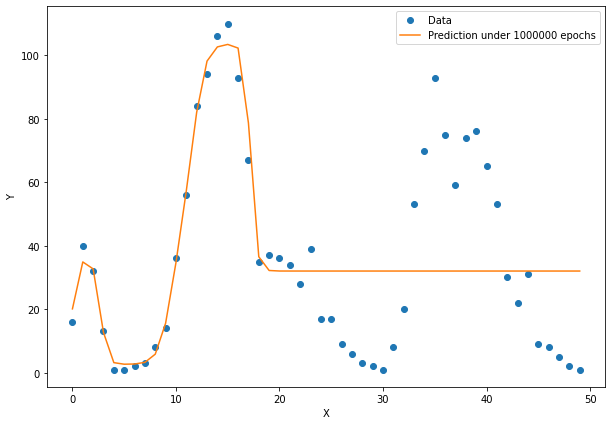

In [11]:
x_data = x.data.numpy()  #获得x包裹的数据
plt.figure(figsize=(10, 7))  #设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o')  #绘制原始数据
yplot, = plt.plot(x_data, predictions.data.numpy())  #绘制拟合数据
plt.xlabel('X')  #更改坐标轴标注
plt.ylabel('Y')  #更改坐标轴标注
plt.legend([xplot, yplot], ['Data', 'Prediction under 1000000 epochs'])  #绘制图例
plt.show()

In [10]:
"""
x的取值范围是1~50，而所有权重和偏置的初始值都是被设定在(-1, 1)的正态分布随机数，那么输入层到隐含层节点的数值范围就成了-50~50，要想将sigmoid函数的多个峰值调节到我们期望的位置需要耗费很多计算时间。事实上，如果让训练时间更长些，我们可以将曲线后面的部分拟合得很好。

这个问题的解决方法是将输入数据的范围做归一化处理，也就是让x的输入数值范围为0~1。因为数据中x的范围是1~50，所以，我们只需要将每一个数值都除以50就可以了
"""

In [12]:
x = torch.FloatTensor(np.arange(len(counts), dtype=float) / len(counts))

In [13]:
learning_rate = 0.001  #设置学习率
losses = []  #该数组记录每一次迭代的损失函数值，以方便后续绘图
x = x.view(50, -1)
y = y.view(50, -1)
for i in range(100000):
    #从输入层到隐含层的计算
    hidden = x * weights + biases
    #此时，hidden变量的尺寸是：(50,10)，即50个数据点，10个隐含层神经元

    #将sigmoid函数作用在隐含层的每一个神经元上
    hidden = torch.sigmoid(hidden)
    #隐含层输出到输出层，计算得到最终预测
    predictions = hidden.mm(weights2)
    #此时，predictions的尺寸为：(50,1)，即50个数据点的预测数值
    #通过与数据中的标准答案y做比较，计算均方误差
    loss = torch.mean((predictions - y) ** 2)
    #此时，loss为一个标量，即一个数
    losses.append(loss.data.numpy())

    if i % 10000 == 0:  #每隔10000个周期打印一下损失函数数值
        print('loss:', loss)

    #*****************************************
    #接下来开始梯度下降算法，将误差反向传播
    loss.backward()  #对损失函数进行梯度反传

    #利用上一步计算中得到的weights，biases等梯度信息更新weights或biases的数值
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)

    #清空所有变量的梯度值
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()

loss: tensor(1118.3237, grad_fn=<MeanBackward0>)
loss: tensor(835.4456, grad_fn=<MeanBackward0>)
loss: tensor(594.3510, grad_fn=<MeanBackward0>)
loss: tensor(410.9413, grad_fn=<MeanBackward0>)
loss: tensor(196.0895, grad_fn=<MeanBackward0>)
loss: tensor(131.9430, grad_fn=<MeanBackward0>)
loss: tensor(114.9470, grad_fn=<MeanBackward0>)
loss: tensor(108.8699, grad_fn=<MeanBackward0>)
loss: tensor(105.6640, grad_fn=<MeanBackward0>)
loss: tensor(103.4669, grad_fn=<MeanBackward0>)


Text(0, 0.5, 'Loss')

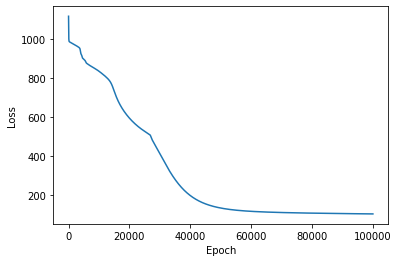

In [14]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

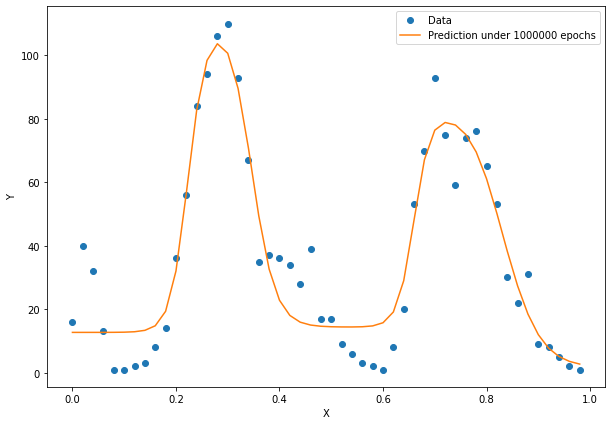

In [15]:
x_data = x.data.numpy()  #获得x包裹的数据
plt.figure(figsize=(10, 7))  #设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o')  #绘制原始数据
yplot, = plt.plot(x_data, predictions.data.numpy())  #绘制拟合数据
plt.xlabel('X')  #更改坐标轴标注
plt.ylabel('Y')  #更改坐标轴标注
plt.legend([xplot, yplot], ['Data', 'Prediction under 1000000 epochs'])  #绘制图例
plt.show()

tensor(4809.3110, grad_fn=<MeanBackward0>)


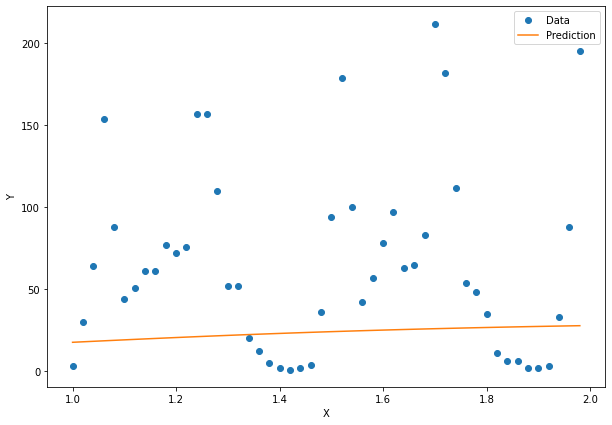

In [31]:
counts_predict = rides['cnt'][50:100]  #读取待预测的后面50个数据点
x = torch.FloatTensor((np.arange(len(counts_predict), dtype = float) + len(counts)) / len(counts))
#读取后面50个点的y数值，不需要做归一化
y = torch.FloatTensor(np.array(counts_predict, dtype = float))

#用x预测y
hidden = x.expand(sz, len(x)).t() * weights.expand(len(x), sz)  #从输入层到隐含层的计算
hidden = torch.sigmoid(hidden)  #将sigmoid函数作用在隐含层的每一个神经元上
predictions = hidden.mm(weights2)  #从隐含层输出到输出层，计算得到最终预测
loss = torch.mean((predictions - y) ** 2)  #计算预测数据上的损失函数
print(loss)

#将预测曲线绘制出来
x_data = x.data.numpy()  #获得x包裹的数据
plt.figure(figsize = (10, 7)) #设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o') #绘制原始数据
yplot, = plt.plot(x_data, predictions.data.numpy())  #绘制拟合数据
plt.xlabel('X')  #更改坐标轴标注
plt.ylabel('Y')  #更改坐标轴标注
plt.legend([xplot, yplot],['Data', 'Prediction'])  #绘制图例
plt.show()